# Final Project Baseline
Yang Wei Neo, Emily Rapport, Hilary Yamtich

## Load Libraries and Data

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# note: this notebook requires pandas 0.21.0 or newer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import testing_utils as testing
import model_training_utils as model_train
import ensemble_model_utils as ensemble
import math
from datetime import datetime as dt
import re as re
import pickle as pk

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

import warnings
warnings.filterwarnings('ignore')

from dateutil import parser
import datetime

In [2]:
# Load the pickle file that contains the clean data and other useful stuff?
with open('./clean_data_pickle','rb') as infile:
    data = pk.load(infile)

with open('clean_test_data.pkl', 'rb') as infile:
    kaggle_test_data = pk.load(infile)
    
feature_importances = pd.read_csv('feature_importance.csv')
feature_importances.columns = ['feature', 'importance']

--------

# Cross Validation

We started with a simple 15% dev set, but we have found that for this amount of data, the differences in the models and their scores on the dev sets can vary significantly based on which rows end up in the train and dev sets. Repeated random sub-sampling cross validation helps us get more consistent results.

Note that we do not split out the dev data using the most recent years, which would be the proper way to create a dev set if our task were explicitly to predict future home prices. The test data appears to have rows from all the years represented in the train set, so we built dev sets that sample from across the train set. 

In [3]:
# get the list of different cross val splits
NUM_CROSS_VALS = 1 # TODO change this back

cross_val_list = []
for i in range(NUM_CROSS_VALS):
    split_idx = int(data.shape[0] * .85)
    # line below is what shuffles
    data = data.sample(frac=1)
    train_df = data[:split_idx]
    dev_df = data[split_idx:]
    split_dict = {'train_df': train_df,
                  'dev_df': dev_df}
    cross_val_list.append(split_dict)

## Error Metric

As our primary error metric, we focus on the root mean squared error of the logarithm of the prices, which is the error metric being used to create the leaderboard for this kaggle competition. See rmsle() in shared_functions.py for our implementation of the root mean squared logarithmic error, an implementation we found from Mark Nagelberg on Kaggle: https://www.kaggle.com/marknagelberg/rmsle-function. Note that this adds 1 to each target and *marginally* inflates the underlying target. 

Note, however, that the rmsle is not necessarily the same error metric that is used consistently in all of the underlying models. In some cases minimizing another error metric may result in minimizing the rmsle (e.g. minimizing sum of squares will minimize root mean logarthmic error). But in other cases, such as the kNN, which minimizes Euclidean distance, it is not clear to us that it necessarily solves for rmsle. 


## Get Baseline

When we consulted our resident real estate expert, Hilary's dad, about this problem, he told us that only one of these factors matters - "location, location, location." In the spirit of that insight, we created a baseline "model" which looks at what neighborhood the house is in and takes the mean price of houses from that neighborhood in the training set. 

In [4]:
# todo: figure out why i'm getting nans now
# when i wasn't in original notebook
def baseline_pred(row,
                  train_df):
    for col in train_df:
        if 'Neighborhood' in col:
            if row[col] == 1:
                neighborhood_var = col
                break
    return np.nanmean(train_df[train_df[neighborhood_var]==1]['LogSalePrice'])

def get_baseline_cross_val(cross_val_list):
    all_rmses = []
    for di in cross_val_list:
        dev_df = di['dev_df']
        dev_df['baseline_pred'] = dev_df.apply(lambda row: baseline_pred(row,
                                                                         di['train_df']), axis=1)
        rmse = testing.rmsle(list(np.exp(dev_df['LogSalePrice'])), list(np.exp(dev_df['baseline_pred'])))
        all_rmses.append(rmse)
    return np.nanmean(all_rmses) 

# baseline RMSLE
print("Baseline RMSLE: {:.3f}".format(get_baseline_cross_val(cross_val_list)))

Baseline RMSLE: 0.264


With this as a baseline, we began exploring how different types of models perform on the problem.

## Model Exploration 
#### Linear Regression

We begin with linear regression as the standard choice for a regression problem. In ordinary least squares regression, the regression line is fit by minimizing the sum of squared residuals between the predicted line and the true data points. We can interpret the resulting coefficients on each feature as representing the additional impact of a one-unit change in that feature on the final price.

- Will not work well with variables that are highly correlated with each other (note that OneHotEncoding is technically not the right solution here as one category will be a linear combination of the others, but the model will drop it anyway).
- Indeed this is why linear regression with PCA seems to do just as well as the original variables since each principal component is orthogoal to one another the  loss is not as great for linear regression (only 0.04 loss in RMSLE).
- We find that the simple, unembellished linear regression is extremely effective relative to the baseline. With some simple hyperparameter tuning we find that the Lasso ultimately does best, as it allows us to remove entire features altogether- this suggests that we have too many (redundant) features, such as GarageCars and Garage SqFt. Indeed it makes sense then that the Ridge regression with an extremely large regularization parameter then does second best. The elasticnet which strikes a balance of the L1/L2 regularization seems to do worst.

In [5]:
# Set up different LR models
models_to_param_list = {LinearRegression: [{}], 
                        Lasso: [{'alpha': 0.001}], # lower value is less regularization
                        Ridge: [{'alpha': 50}], # more effective with more regularization
                        ElasticNet: [{'alpha': 0.005}]} # lower value is less regularization

# Outcome 
outcome_vars = ['LogSalePrice']

# Create feature sets
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice']]]

# Output model
lr_models = model_train.try_different_models(cross_val_list, 
                                        models_to_param_list,
                                        outcome_vars, 
                                        feature_sets)

lr_models_forensemble = lr_models.sort_values('Root MSE', ascending=True)
lr_models_forensemble

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
1,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[Lasso(alpha=0.001, copy_X=True, fit_intercept...",232,LogSalePrice,{'alpha': 0.001},0.117020,0.120353
2,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[Ridge(alpha=50, copy_X=True, fit_intercept=Tr...",232,LogSalePrice,{'alpha': 50},0.122824,0.123052
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[LinearRegression(copy_X=True, fit_intercept=T...",232,LogSalePrice,{},0.125213,0.099891
3,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[ElasticNet(alpha=0.005, copy_X=True, fit_inte...",232,LogSalePrice,{'alpha': 0.005},0.128953,0.137815


### Bagging Illustration

Bagging, or bootstrap aggregation, is intended to reduce variance in the test error by averaging predictions over very specialized models. While each of these models in isolation is likely to overfit, the ensemble of specialized models ends up being very effective at reducing overall test error. To stress test this assumption, we run several random forest ensembles on models that are increasingly less likely to *individually* overfit. We find that the more likely each individual model is to overfit (either by enforcing a smaller minimum leaf, or by enforcing a higher split size), the lower the error of the ensemble as a whole. We suspect that this is because a large ensemble paired with high variance/low bias individual models gives the best of both worlds.

Note however that this phenomenon is not true when we increase the proportion of features used to split at each node (causing any given individual tree to be more likely to overfit). We aren't sure why - perhaps the choice of features increases signal in the underlying data while increasing the complexity of each tree, and the former may offset effects from the latter. 

Another interesting phenomenon is that the difference between the training and test error decreases as each individual model within the ensemble gets less complex. This is a sign of increasing bias in the underlying model, which makes sense, since each model is more likely to underfit since it has less underlying complexity. 

This analysis suggests that we ought to lean towards creating more complex individual trees (low bias); the higher variance that results from this ought be offset by the bootstrap aggregation procedure. We will use a grid search to find the optimal combination of parameters. 

In [6]:
# Initialize list of tests:
param_list = []

# Create list of parameter types
for min_leaf_size in range(10):
    param_list.append({'min_samples_leaf': min_leaf_size, 'n_estimators': 50})
    
for feature_prop in range(10):
    param_list.append({'max_features': feature_prop/10, 'n_estimators': 50})
                       
for split_size in range(11):
    param_list.append({'min_samples_split': split_size, 'n_estimators': 50})


In [7]:
# Run models to show the impact of bagging
### THIS TAKES A LONG TIME TO RUN
models_to_param_list = {RandomForestRegressor: param_list}
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice']]]

# Run different random forests
df = model_train.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)

df_forensemble = df.sort_values('Root MSE', ascending=True)


Text(0.5,0.98,'Bagging with High Variance Models')

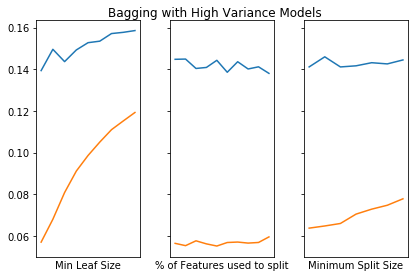

In [8]:
# Plot the data
fig, ax = plt.subplots(1,3, sharey='row')
fig.tight_layout(pad = 1.5)

for i in range(3):
    ax[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

ax[0].plot(df.iloc[0:9]['Root MSE'])
ax[0].plot(df.iloc[0:9]['Train MSE'])
ax[0].set_xlabel('Min Leaf Size')

ax[1].plot(df.iloc[10:20]['Root MSE'])
ax[1].plot(df.iloc[10:20]['Train MSE'])
ax[1].set_xlabel('% of Features used to split')

ax[2].plot(df.iloc[20:30]['Root MSE'])
ax[2].plot(df.iloc[20:30]['Train MSE'])
ax[2].set_xlabel('Minimum Split Size')

fig.suptitle('Bagging with High Variance Models')


# !!! remove the axis tick marks

### Boosting Illustration

In contrast, boosting is a process that reduces bias by refitting the model iteratively on the errors from the previous model. Boosting can turn weak learners into a accurate ensemble - we can see this below by showing how a relatively weak learner (tree of depth 3) actually appears to have really good accuracy when boosted. In this case we use a gradient boosting regressor to illustrate this. In particular notice how the accuracy is higher on weak learners (less depth) than on strong learners (deeper depth). However, GBMs do have a tendency towards high variance (as seen by how quickly the model overfits the training data relative to the test data). 

In [9]:
# Initialize list of tests:
param_list = []
# Create list of parameter types
for depth in range(20):
    param_list.append({'max_depth': depth, 'n_estimators': 50})

In [10]:
# Run Gradient Boosting Results
models_to_param_list = {GradientBoostingRegressor: param_list}
df_boosting = model_train.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)
df_boosting_forensemble = df_boosting.sort_values('Root MSE', ascending=True)

Text(0,0.5,'Error')

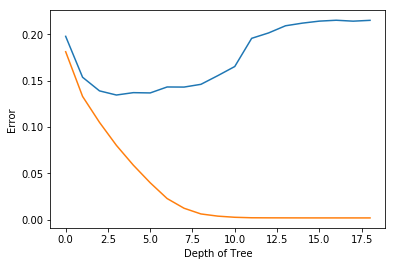

In [11]:
# Plot the DF Boosting Results.
plt.plot(df_boosting.index, df_boosting['Root MSE'])
plt.plot(df_boosting.index, df_boosting['Train MSE'])
plt.xlabel('Depth of Tree')

plt.ylabel('Error')

### Bayesian Ridge 

Bayesian ridge is a form of ridge regression, a type of regression which imposes a penalty on the size of the coefficients. In the Bayesian form of ridge regression, the parameters are estimated using a Gaussian prior. The coefficients, as well as the parameters of the Gaussian distribution (mean and variance) are estimated from the data using maximum likelihood estimation. 

In [12]:
## see how shape of coefficients changes as number of iterations goes up 
param_list = []
for num_iter in range(1, 41):
    param_list.append({'n_iter': num_iter})
    
models_to_param_dict = {BayesianRidge: param_list}

df = model_train.try_different_models(cross_val_list, 
                                      models_to_param_dict,
                                      ['SalePrice'], 
                                      feature_sets)

In [13]:
df.shape

(40, 7)

In [14]:
# see how root MSE changes quickly with first few iterations, then more slowly 
# there is some evidence of overfitting at the end as train MSE continues to fall
# while Root MSE starts to plateau or rise slightly 
select_models = df.iloc[[0, 1, 2, 3, 4, 9, 14, 19, 24, 29, 34, 39]]
select_models

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
0,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 1},0.388819,0.377999
1,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 2},0.272819,0.267832
2,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 3},0.183808,0.195425
3,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 4},0.178034,0.186715
4,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 5},0.183521,0.187531
9,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 10},0.185670,0.186771
14,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 15},0.140569,0.156334
19,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 20},0.132406,0.130028
24,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 25},0.133875,0.129328
29,"[Id, MSSubClass, LotFrontage, LotArea, Overall...","[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, c...",232,SalePrice,{'n_iter': 30},0.133955,0.129290


Below, we can plot how the value of the full set of coefficients changes over subsequent model iterations (proxied by training separate models using increasing numbers of iterations). The distribution of coefficients approaches a normal distribution centered at 0, in accordance with the Gaussian prior.

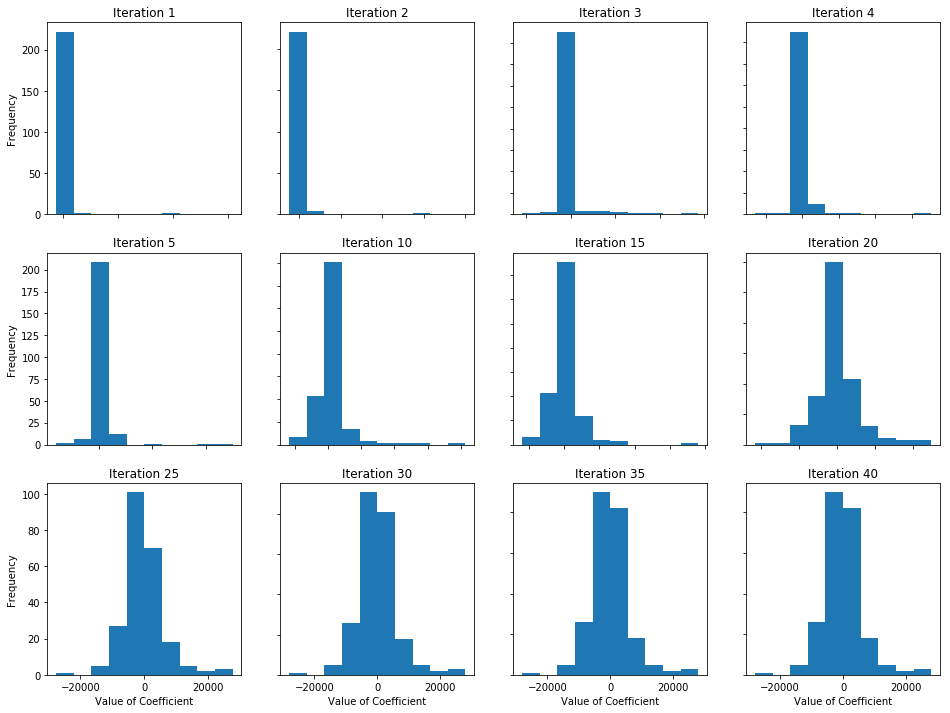

In [15]:
models = [models[0] for models in select_models.Model.values]
iteration_nums = [num+1 for num in select_models.index.values]
coefficients = [model.coef_ for model in models]

counter = 0
f, axarr = plt.subplots(3,4, figsize=(16,12))
for i in range(3):
    for j in range(4):
        axarr[i,j].hist(coefficients[counter])
        axarr[i,j].set_title("Iteration {}".format(iteration_nums[counter]))
        counter += 1
for ax in axarr.flat:
    ax.set(xlabel='Value of Coefficient', ylabel='Frequency')
for ax in axarr.flat:
    ax.label_outer()

### KNearest Neighbors

We experimented with a K Neighbors Regressor, which identifies the k nearest neighbors of the given example and averages their target variables in order to obtain a prediction. A drawback of the K Neighbors algorithm is that it is not able to learn relative importance of different features; as a result, it struggles as the number of features increases.  

In [16]:
k_feature_sets_to_try = []

for i in range(1,75):
    set_to_try = list(feature_importances.feature.values)[:(i)]
    set_to_try = [item for item in set_to_try if item not in ['SalePrice', 'LogSalePrice']]
    k_feature_sets_to_try.append(set_to_try)

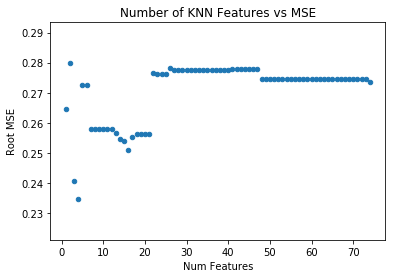

In [17]:
## to do: would also be fun to see how this changes as k changes, but maybe not that important  
models_to_param_dict = {KNeighborsRegressor: [{}]}

k_df = model_train.try_different_models(cross_val_list, 
                                        models_to_param_dict,
                                        ['SalePrice'], 
                                         k_feature_sets_to_try)
k_df.plot.scatter(x='Num Features', y='Root MSE', title='Number of KNN Features vs MSE')

The plot above shows how the root MSE changes as the number of features changes. As the first few features get added in, there's significant instability in the error, as each new feature drastically changes the estimation of which data point is closest. We see that after the error stabilizes, the general trend is an increase in error as more features are added, which makes sense, since the features that get added later on are less important, and this model has no way of handling less inportant features. Additionally, we see significant periods of plateau, where new features do not cause any change in error. This is likely due to the sparsity of our data set, since many of our features are dummy variables for different values of categories, and those variables are often very sparse (many 0 values across the data set). The sheer number of features, combined with the relative sparsity of our set, make K Neighbors a poor choice for this problem. 

### Ensembling Techniques

#### Stacking

We use stacking as a method of ensembling. Stacking involves training a meta-model on the underlying models. This is intended to give greater weights to models that are more accurate (instead of arbitrarily assigning weights to each or simple-averaging across them). The stacking model itself also need not be a linear model. We hypothesize that given a similar level of accuracy, models that generate predictions that are different from each other will do better in an ensemble, and this is also true of a stacked ensemble. To explore this idea we use a simple linear regression on the outputs of each of the given underlying models. 

By comparing several different models and plotting their predictions against in a scatterplot matrix, we see that:
- Not all models have a linear relationship with the final prediction: the boosted model appears to have more variation for any given level of the final prediction and tapers off at the end 
- Some models generate an extremely skewed data point (Linear Regression and RF) relative to the final regression. In the same vein the shape of the distribution for each model prediction can very substantially.
- However, the models are generally correlated with each other, suggesting that the ensemble of them may not be very successful (indeed this is what we find, the stacked ensemble does not perform much better)

This makes us think that a simple voting / averaging technique may be equally or more effective, and indeed we find that to be the case when we apply a simple weighting scheme across different model predictions. 

In [18]:
kagglepred = testing.stack_ensemble(train_data = data,
                              dev_data = kaggle_test_data, 
                              model1 = testing.get_best_specs_from_each_family(df_boosting), # boosting
                              model2 = testing.get_best_specs_from_each_family(lr_models), # LR
                              model3 = testing.get_best_specs_from_each_family(df),# bagging,
                              kaggle_flag = True) 

kagglepred2 = pd.concat([pd.DataFrame({'final_pred': kagglepred[0]}), kagglepred[1]], axis = 1)

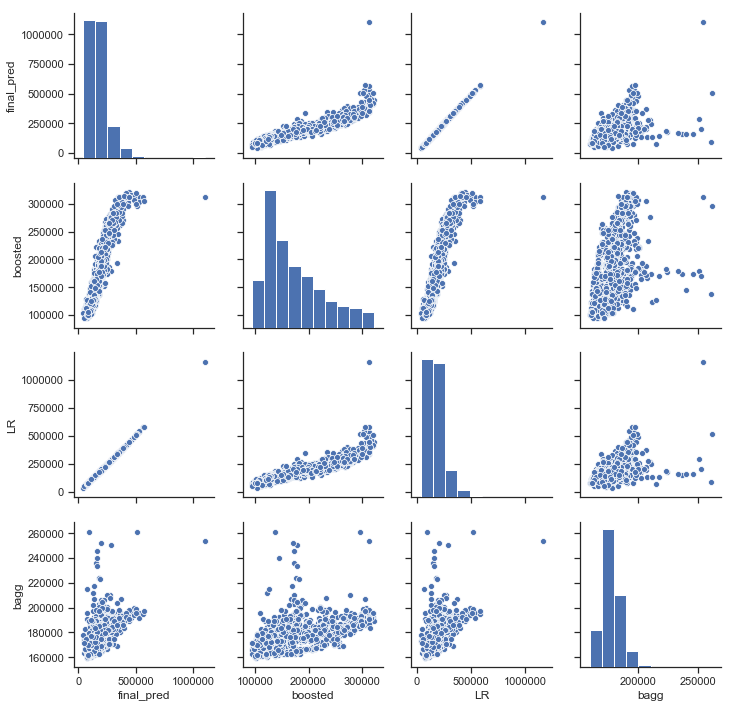

In [19]:
sns.set(style="ticks")
sns.pairplot(kagglepred2)


#### Voting & Avergaging

In [20]:
# train the base models of each type
feature_sets_to_try = []

set_to_try = list(feature_importances.feature.values)
set_to_try = [item for item in set_to_try if item not in ['SalePrice', 'LogSalePrice']]
feature_sets_to_try.append(set_to_try)

In [21]:
# make random forest match gradient boosted in terms of number of estimators
models_to_param_list = {GradientBoostingRegressor: [{}],
                        LinearRegression: [{}],
                        BayesianRidge: [{}]}
outcome_vars = ['LogSalePrice', 'SalePrice']

df = model_train.try_different_models(cross_val_list, 
                                      models_to_param_list,
                                      outcome_vars, 
                                      feature_sets_to_try)

In [22]:
new_df = df[6:]
new_df

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE


In [23]:
to_use = df.iloc[[3,4,5,6,7,8,9,10,11,12,13,14]]
#!!!

IndexError: positional indexers are out-of-bounds

Our best attempts at ensembling came when we tried different variations of voting ensembles where each preciction is an average of the predictions of individual models in the ensemble. The intuition here is that different types of models will error in different types of ways, so if one type of model - say, a linear model - has a bias that disproportionately causes errors on certain types of rows, then averaging those predictions with that of a model - say, tree-based - that better handles those rows would pull bad predictions back in the right direction. 

We used a combination of experimentation and theory to guide our selection of different voting ensembles. We watched our Kaggle leaderboard position go up as we made changes to these ensembles, and learned the following:
- **Linear + tree-based ensembles work well overall**: We know that linear models tend to have errors born out of bias in the specification, whereas tree-based models tend to have errors born out of variance. It makes sense that averaging predictions from these types of models would help counteract the errors specific to each type. (NOTE: this could be where the error correlation table goes, and we could show how like a linear reg and a tree based model have errors that are correlated really differently) 

In [24]:
# !!!
### i don't know if this is good to show or not....? not sure it makes the point 
models_for_error_analysis = ensemble.get_model_dicts_from_data_frame(df)

# table for our LR with all the features
lr_corrs_df = testing.create_error_correlation_table([models_for_error_analysis[2]], dev_df)
lr_corrs_df.reindex(lr_corrs_df.avg_correlation.abs().sort_values(ascending=False).index). \
            filter(['col','avg_correlation'])[:10]

TypeError: create_error_correlation_table() missing 2 required positional arguments: 'feature_set' and 'dev_df'

In [25]:
boost_corrs_df = testing.create_error_correlation_table([models_for_error_analysis[0]], dev_df)
boost_corrs_df.reindex(boost_corrs_df.avg_correlation.abs().sort_values(ascending=False).index). \
               filter(['col','avg_correlation'])[:10]

TypeError: create_error_correlation_table() missing 2 required positional arguments: 'feature_set' and 'dev_df'

- **But - it's not as good as it looks: **While the scores in this table suggest that we should be at the top of the leaderboard, we found that there was a serious discrepancy between how our ensembles scored on our cross-validated dev sets versus on Kaggle. We're not totally sure why, other than the fact that the dev sets are significantly smaller than the Kaggle test set and, thus, might note be the truest possible reflecting of the error. 

In [26]:
# make ensembles of each
models = ensemble.get_model_dicts_from_data_frame(df)

# index 0 bellow
lin_and_rf = [models[3], models[4]]

# index 1
lin_and_boost = [models[3], models[1]]

# index 2
bayes_and_rf = [models[0], models[4]]

# index 3
bayes_and_boost = [models[0], models[1]]

# index 4
lin_and_bayes = [models[3], models[1]]

# index 5
rf_and_boost = [models[1], models[4]]

voting_ensembles_df = ensemble.try_different_voting_ensembles(cross_val_list,
                                                              [lin_and_rf,
                                                               lin_and_boost,
                                                               bayes_and_rf,
                                                               bayes_and_boost,
                                                               lin_and_bayes,
                                                               rf_and_boost])
voting_ensembles_df.sort_values('RMSE for ensemble', ascending=True)

,Features,Models,Num features in each,Outcome_Vars,RMSE for ensemble
2,"[[OverallQual, 2ndFlrSF, 1stFlrSF, BsmtFinSF1,...",[([DecisionTreeRegressor(criterion='friedman_m...,"[233, 233]","[LogSalePrice, LogSalePrice]",0.115326
5,"[[OverallQual, 2ndFlrSF, 1stFlrSF, BsmtFinSF1,...",[([DecisionTreeRegressor(criterion='friedman_m...,"[233, 233]","[SalePrice, LogSalePrice]",0.119143
0,"[[OverallQual, 2ndFlrSF, 1stFlrSF, BsmtFinSF1,...","[LinearRegression(copy_X=True, fit_intercept=T...","[233, 233]","[SalePrice, LogSalePrice]",0.123566
1,"[[OverallQual, 2ndFlrSF, 1stFlrSF, BsmtFinSF1,...","[LinearRegression(copy_X=True, fit_intercept=T...","[233, 233]","[SalePrice, SalePrice]",0.125828
4,"[[OverallQual, 2ndFlrSF, 1stFlrSF, BsmtFinSF1,...","[LinearRegression(copy_X=True, fit_intercept=T...","[233, 233]","[SalePrice, SalePrice]",0.125828
3,"[[OverallQual, 2ndFlrSF, 1stFlrSF, BsmtFinSF1,...",[([DecisionTreeRegressor(criterion='friedman_m...,"[233, 233]","[LogSalePrice, SalePrice]",0.128213


- **Weighting the averages towards the linear models (either with a weighting average, or by including more linear models) tends to work well**: Our linear models tend to predict better than our tree-based ensembles overall, so weighting our ensembles towards linear models helped us capture the best predictions. In general, including multiple linear models works better than overly weighting the predictions of one linear model; this makes sense, as two different linear models could error in different places, such that their averages are better than either one individually.
- **Linear models best predict the logarithmic outcome variable, whereas tree-based models best predict the "true" outcome variable:** We looked at all types of models trained on both types of outcome variables, and in general, we found that each model was best suited to a particular outcome variable in a way that made intuitive sense to us. Since the linear models are confined to linear decision boundaries in making their predictions, they do best predicting on a normally-distributed variable, since outliers are not well-handled by linear boundaries. The logaritmic outcome variable was more normally distributed than the normal outcome variable, so the linear models handled this well. On the other hand, the tree-based models can handle non-linear decision boundaries, as "outlier" type predictions can simply be handled by particular branches in the trees. The non-logarithmic outcome variable preserves more of the variation in the outcome variable (i.e. it makes examples with similar SalePrices look more different than they would look if you took their logarithm), so using the non-logarithmic variable allows the tree-based model to capture more nuanced decision rules that capture the variability in the underlying data. S

### Error Analysis

In this section, we'll go into more detail about how we actually iterated on models and chose whichever ones we end up deciding are our best. Our primary tools will be this error correlation table, which we'll use to look at patterns of errors the model is making, and diagnostics to determine whether or not the model is overfitting. We'll compare different models to each other and explain the model or ensemble that gives us the best results.

#### Cycle one model variation and plot errors 

We look at a series of random forest errors and linear regression errors (not shown) against key features. These errors help us figure out whether we should re-engineer some features to better fit the model. For instance, we notice that the dispersion of errors around 2ndFlrSqFt and WoodDeckSF are high around 0 - perhaps a categorical variable that indicates whether a home has a 2nd floor and whether a home has a wood deck would be a more useful variable to split / create an interaction on. 

In [27]:
model_to_use = lr_models_forensemble.iloc[0]['Model'][0]
model_to_use

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

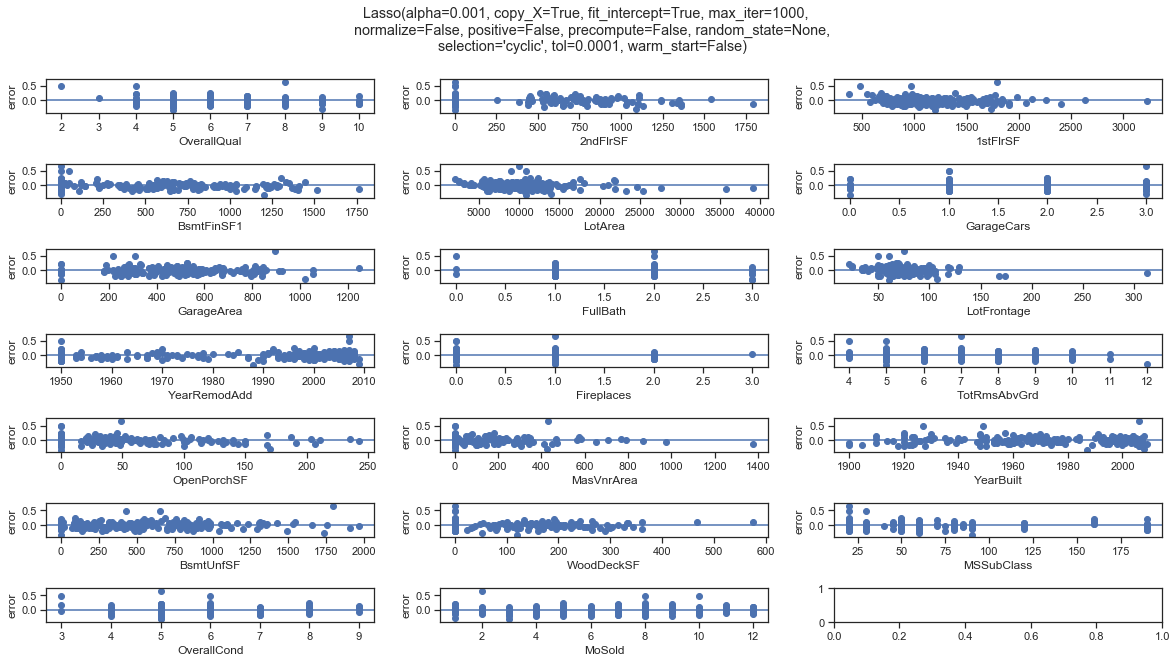

In [28]:
### Random Forest Errors
model_to_use = lr_models_forensemble.iloc[0]['Model'][0]
features_to_use = lr_models_forensemble.iloc[0]['Features']
plot_features = list(feature_importances[:20]['feature'])
testing.plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)


# Final Model & Explanation

TODO

Different models will perform better on different numbers of features. For that reason, it seems worthwhile to try all the individual models we're using on different numbers of features. It will likely be advantageous to ensemble models trained on different numbers of features. 

We'll use feature importances, determined via random forest, in order to decide which features to use. It may also be worthwhile to try some other feature selection methods, or to try random selection. 

In [30]:
feature_importances = pd.read_csv('feature_importance.csv')
feature_importances.columns = ['feature', 'importance']

In [31]:
feature_sets_to_try = []

for i in range(1,24):
    set_to_try = list(feature_importances.feature.values)[:(i * 10)]
    set_to_try = [item for item in set_to_try if item not in ['SalePrice', 'LogSalePrice']]
    feature_sets_to_try.append(set_to_try)

In [32]:
print(ensemble_to_use['Outcome_Vars'])

NameError: name 'ensemble_to_use' is not defined